## Plot decoding plots around each nose poke of reward wells.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)

from spyglass.common.common_interval import _intersection

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,TrialChoiceRemoteReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,find_remote_times,mua_thresholder,
                                   segment_ripples,sort_replays,
                                   classify_ripples,classify_ripple_content,
                                   load_everything,plot_decode_spiking)
from spyglass.shijiegu.load import load_decode,load_position,load_theta,load_ripple,load_spike
from ripple_detection.core import get_envelope
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.load import load_epoch_data
import warnings
warnings.filterwarnings('ignore')

[2024-01-28 17:16:38,996][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
28-Jan-24 17:16:38 Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2024-01-28 17:16:39,036][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
28-Jan-24 17:16:39 Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [9]:
# the only cell to be edited
nwb_file_name = 'eliot20221023.nwb'
#epoch_num=4

In [10]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
TrialChoice() & {'nwb_file_name':nwb_copy_file_name}

*nwb_file_name *epoch    epoch_name     choice_rew
+------------+ +-------+ +------------+ +--------+
eliot20221023_ 2         02_Seq2Session =BLOB=    
eliot20221023_ 4         04_Seq2Session =BLOB=    
eliot20221023_ 6         06_Seq2Session =BLOB=    
eliot20221023_ 8         08_Seq2Session =BLOB=    
 (Total: 4)

In [11]:
IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name}

*position_info *nwb_file_name *interval_list analysis_file_ head_position_ head_orientati head_velocity_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        eliot20221023_ pos 1 valid ti eliot20221023_ 41c96816-f477- 77af3243-47b5- 1b5c9ebf-b6cd-
default        eliot20221023_ pos 3 valid ti eliot20221023_ aa0fee38-5160- 42543339-1b52- f4433840-ffc6-
default        eliot20221023_ pos 5 valid ti eliot20221023_ c8aef2df-718a- 07306297-9f85- 398125c5-3149-
default        eliot20221023_ pos 7 valid ti eliot20221023_ 5572261f-46e8- 7eea333f-141e- 26c4a303-da8a-
default_decodi eliot20221023_ pos 1 valid ti eliot20221023_ 0df93151-fe00- ceaa9be6-434f- ccd288e3-f297-
default_decodi eliot20221023_ pos 3 valid ti eliot20221023_ 3e090433-1305- 92fb0b75-389d- 03c11b1b-f943-
default_decodi eliot20221023_ pos 5 valid ti eliot20221023_ 5a192d99-6a15- 9625ff08-8eb4- cc615104-a51c-
default_decodi eliot20221023_ pos 7 valid ti eliot20221023_ dde33b5b-ae5b- 0cf59288-11eb- fd0c63d7-32ac-
 (Total: 8)

In [12]:
def plot_all_trials(nwb_copy_file_name,epoch_num,likelihood=False):
    offset=1
    
    (epoch_name,
     log_df,
     decode,
     head_speed,head_orientation,linear_position_df,
     theta_df,
     ripple_df,
     neural_df,mua_df,recordings)=load_epoch_data(nwb_copy_file_name,epoch_num)

    # make folder
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    if likelihood:
        exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name+'_Alltrial_likelihood')
    else:
        exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name+'_Alltrial')
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)
        
    # find legal trials
    rewardNum=np.array(log_df.rewardNum)
    legal_trials=(np.argwhere(np.logical_and(rewardNum[1:]>=1,rewardNum[:-1]>=1))+1).ravel()

    trial_ind=np.array(log_df.index)
    
    for t in trial_ind:
        print(t)
        if t==1 or t>80:
            continue

        '''HOME PLOT'''
        t0=log_df.loc[t,'timestamp_H']
        if np.isnan(t0):
            t0=log_df.loc[t-1,'timestamp_O']+2
        t1=log_df.loc[t,'timestamp_O']

        legal=t in legal_trials
        futurepast='future='+str(log_df.loc[t,'future_H'])+' '+'past='+str(log_df.loc[t,'past'])+' '+'pastreward='+str(log_df.loc[t,'past_reward'])

        plot_decode_spiking([t0-offset,t1+offset],np.array([[t0,t1]]),linear_position_df,decode,theta_df,
                            neural_df,mua_df,ripple_df,head_speed,head_orientation,
                            ripple_consensus_trace=None,
                            title=epoch_name+' trial '+str(t)+' legal:'+str(legal)+'\n'+futurepast,
                            savefolder=exampledir,savename=epoch_name+'_trial'+str(t)+'_home',simple=False,
                            likelihood=likelihood)


        '''OUTER PLOT'''
        t0=log_df.loc[t,'timestamp_O']
        try:
            t1=log_df.loc[t+1,'timestamp_H']
            if np.isnan(t1):
                t1=t0+10
        except:
            t1=t0+10
        futurepast='future='+str(log_df.loc[t,'future_O'])+' '+'past='+str(log_df.loc[t,'past'])+' '+'pastreward='+str(log_df.loc[t,'past_reward'])

        plot_decode_spiking([t0-offset,t1+offset],np.array([[t0,t1]]),linear_position_df,decode,theta_df,
                            neural_df,mua_df,ripple_df,head_speed,head_orientation,
                            ripple_consensus_trace=None,
                            title=epoch_name+' trial '+str(t)+' legal:'+str(legal)+'\n'+futurepast,
                            savefolder=exampledir,savename=epoch_name+'_trial'+str(t)+'_outer',simple=False,
                            likelihood=likelihood)


In [26]:
# make a snippet object

[2024-01-28 20:16:28,697][WARNING]: Skipped checksum for file with hash: 6e3e8afc-cb83-0069-5fe9-d43e56a786ff, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_MQOUOFM8SS.nwb
28-Jan-24 20:16:28 Skipped checksum for file with hash: 6e3e8afc-cb83-0069-5fe9-d43e56a786ff, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_MQOUOFM8SS.nwb


epoch name 02_Seq2Session1
epoch_pos_name pos 1 valid times


[2024-01-28 20:16:29,127][WARNING]: Skipped checksum for file with hash: 334ce11f-3d94-4f4c-0f1b-a45ace69cc93, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_95MTWG1XC3.nwb
28-Jan-24 20:16:29 Skipped checksum for file with hash: 334ce11f-3d94-4f4c-0f1b-a45ace69cc93, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_95MTWG1XC3.nwb
[2024-01-28 20:16:29,813][WARNING]: Skipped checksum for file with hash: 69d8c928-159f-8129-b7bc-b32cd7f979a4, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_RSEEM42G4V.nwb
28-Jan-24 20:16:29 Skipped checksum for file with hash: 69d8c928-159f-8129-b7bc-b32cd7f979a4, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_RSEEM42G4V.nwb
[2024-01-28 20:16:31,778][WARNING]: Skipped checksum for file with hash: b659afeb-8863-0fa0-a95d-e21932c60b87, and path: /stelmo/nwb/analysis/eliot20221023/eliot20221023_8094AP8YUU.nwb
28-Jan-24 20:16:31 Skipped checksum for file with hash: b659afeb-8863-0fa0-a95d-e21932c60b87, and path: /stel

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


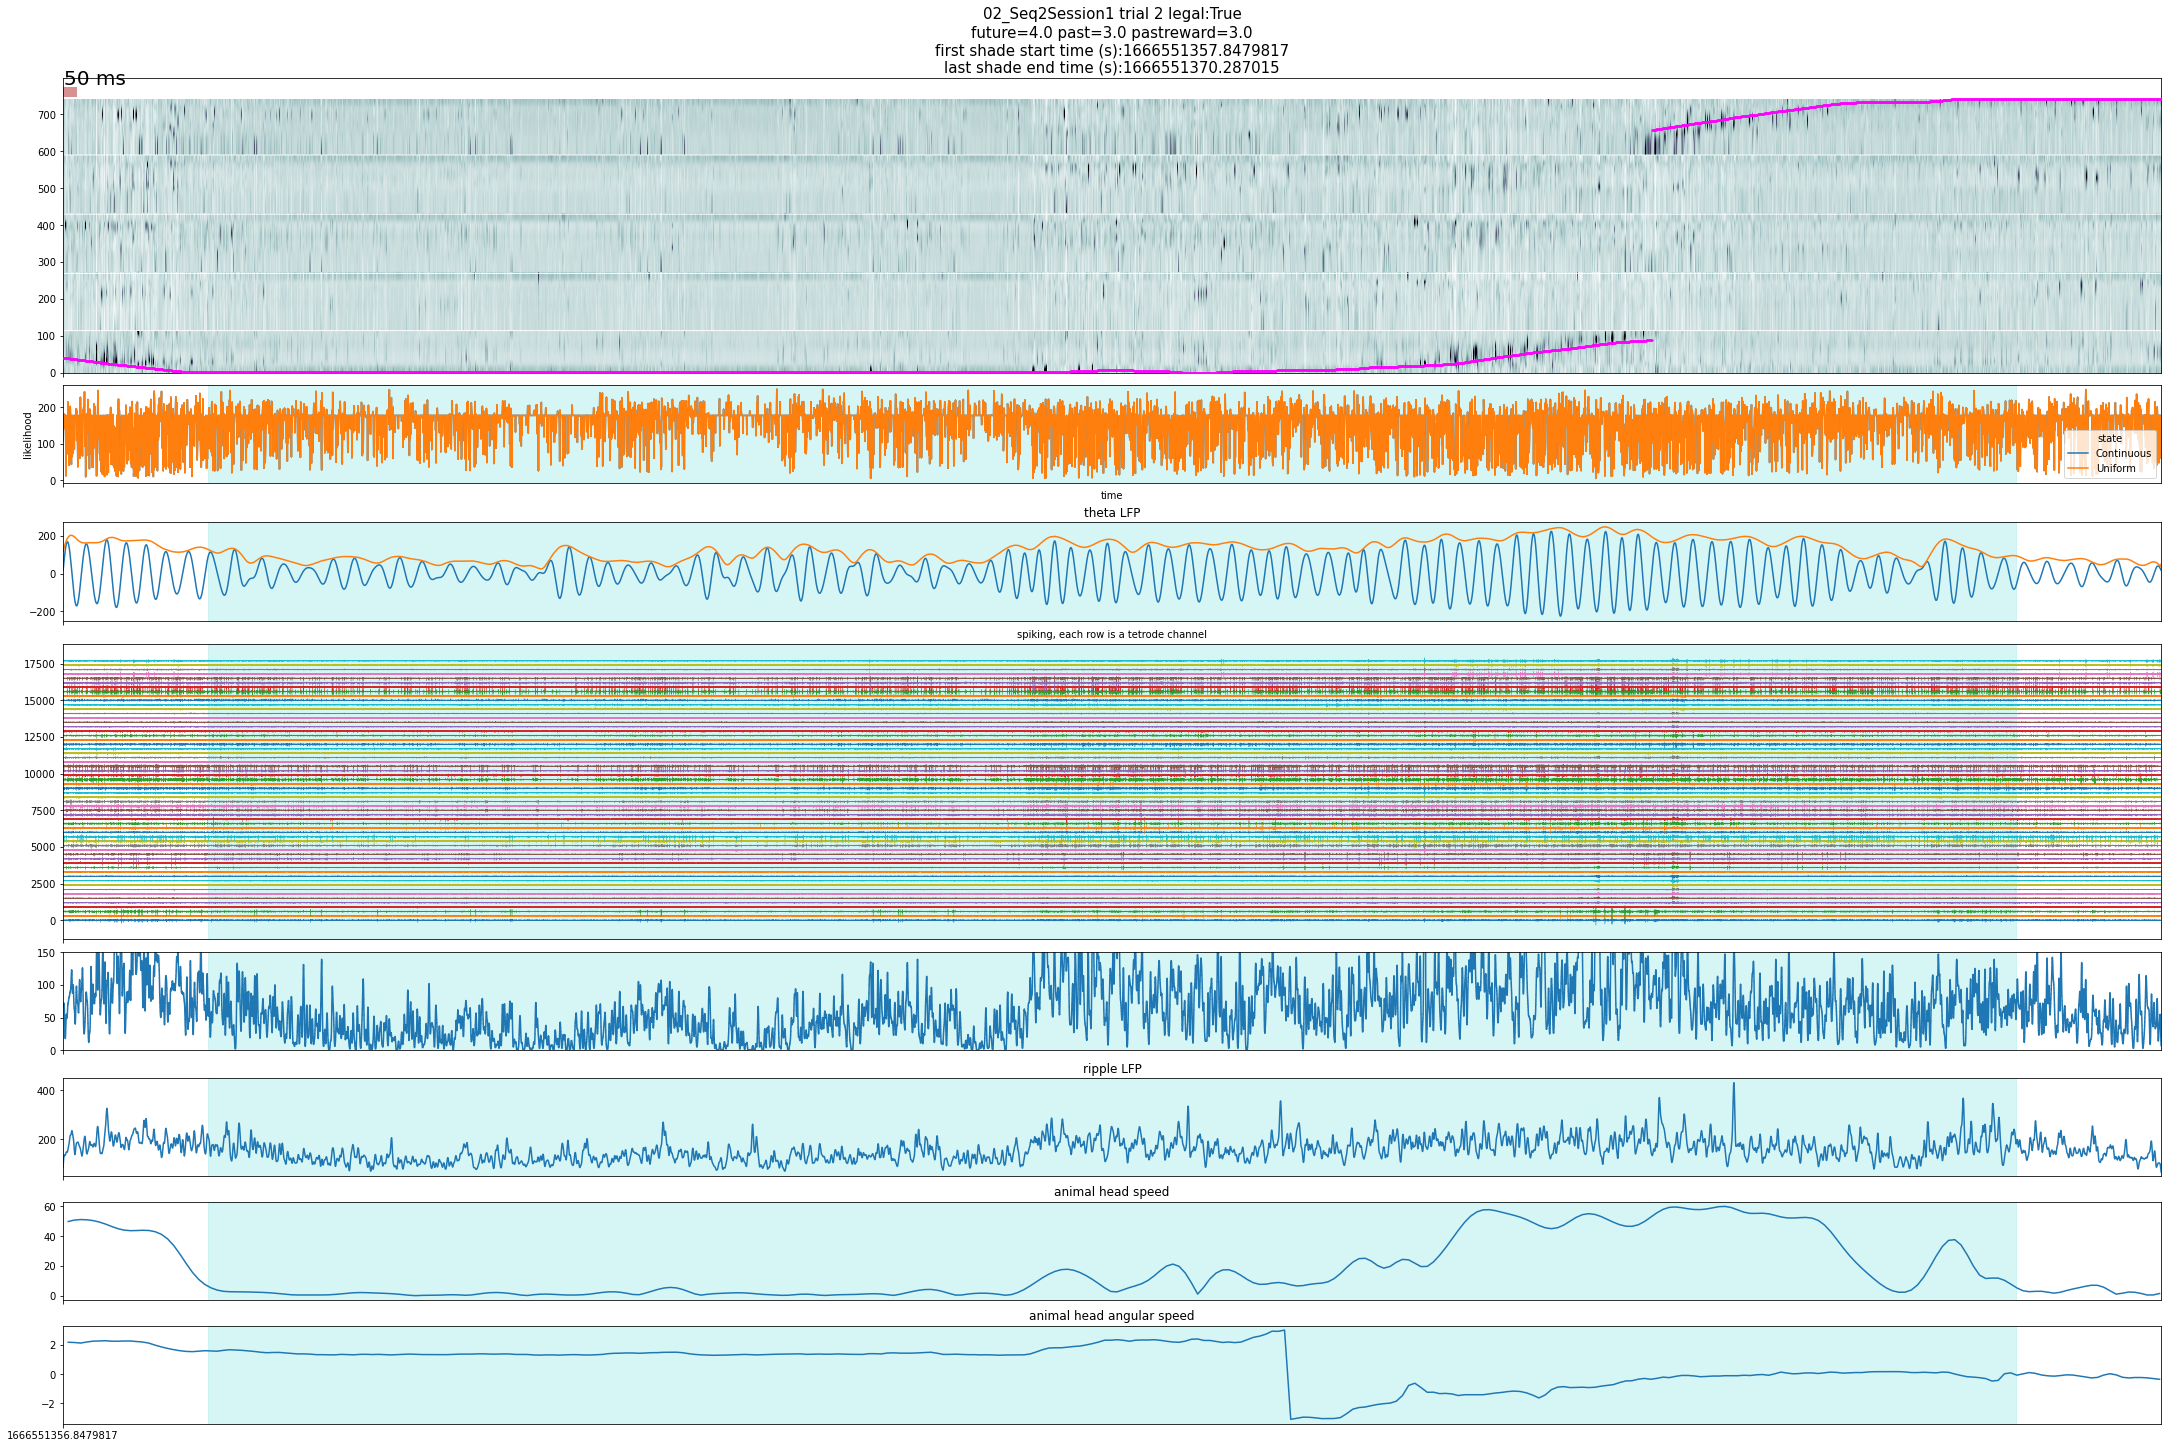

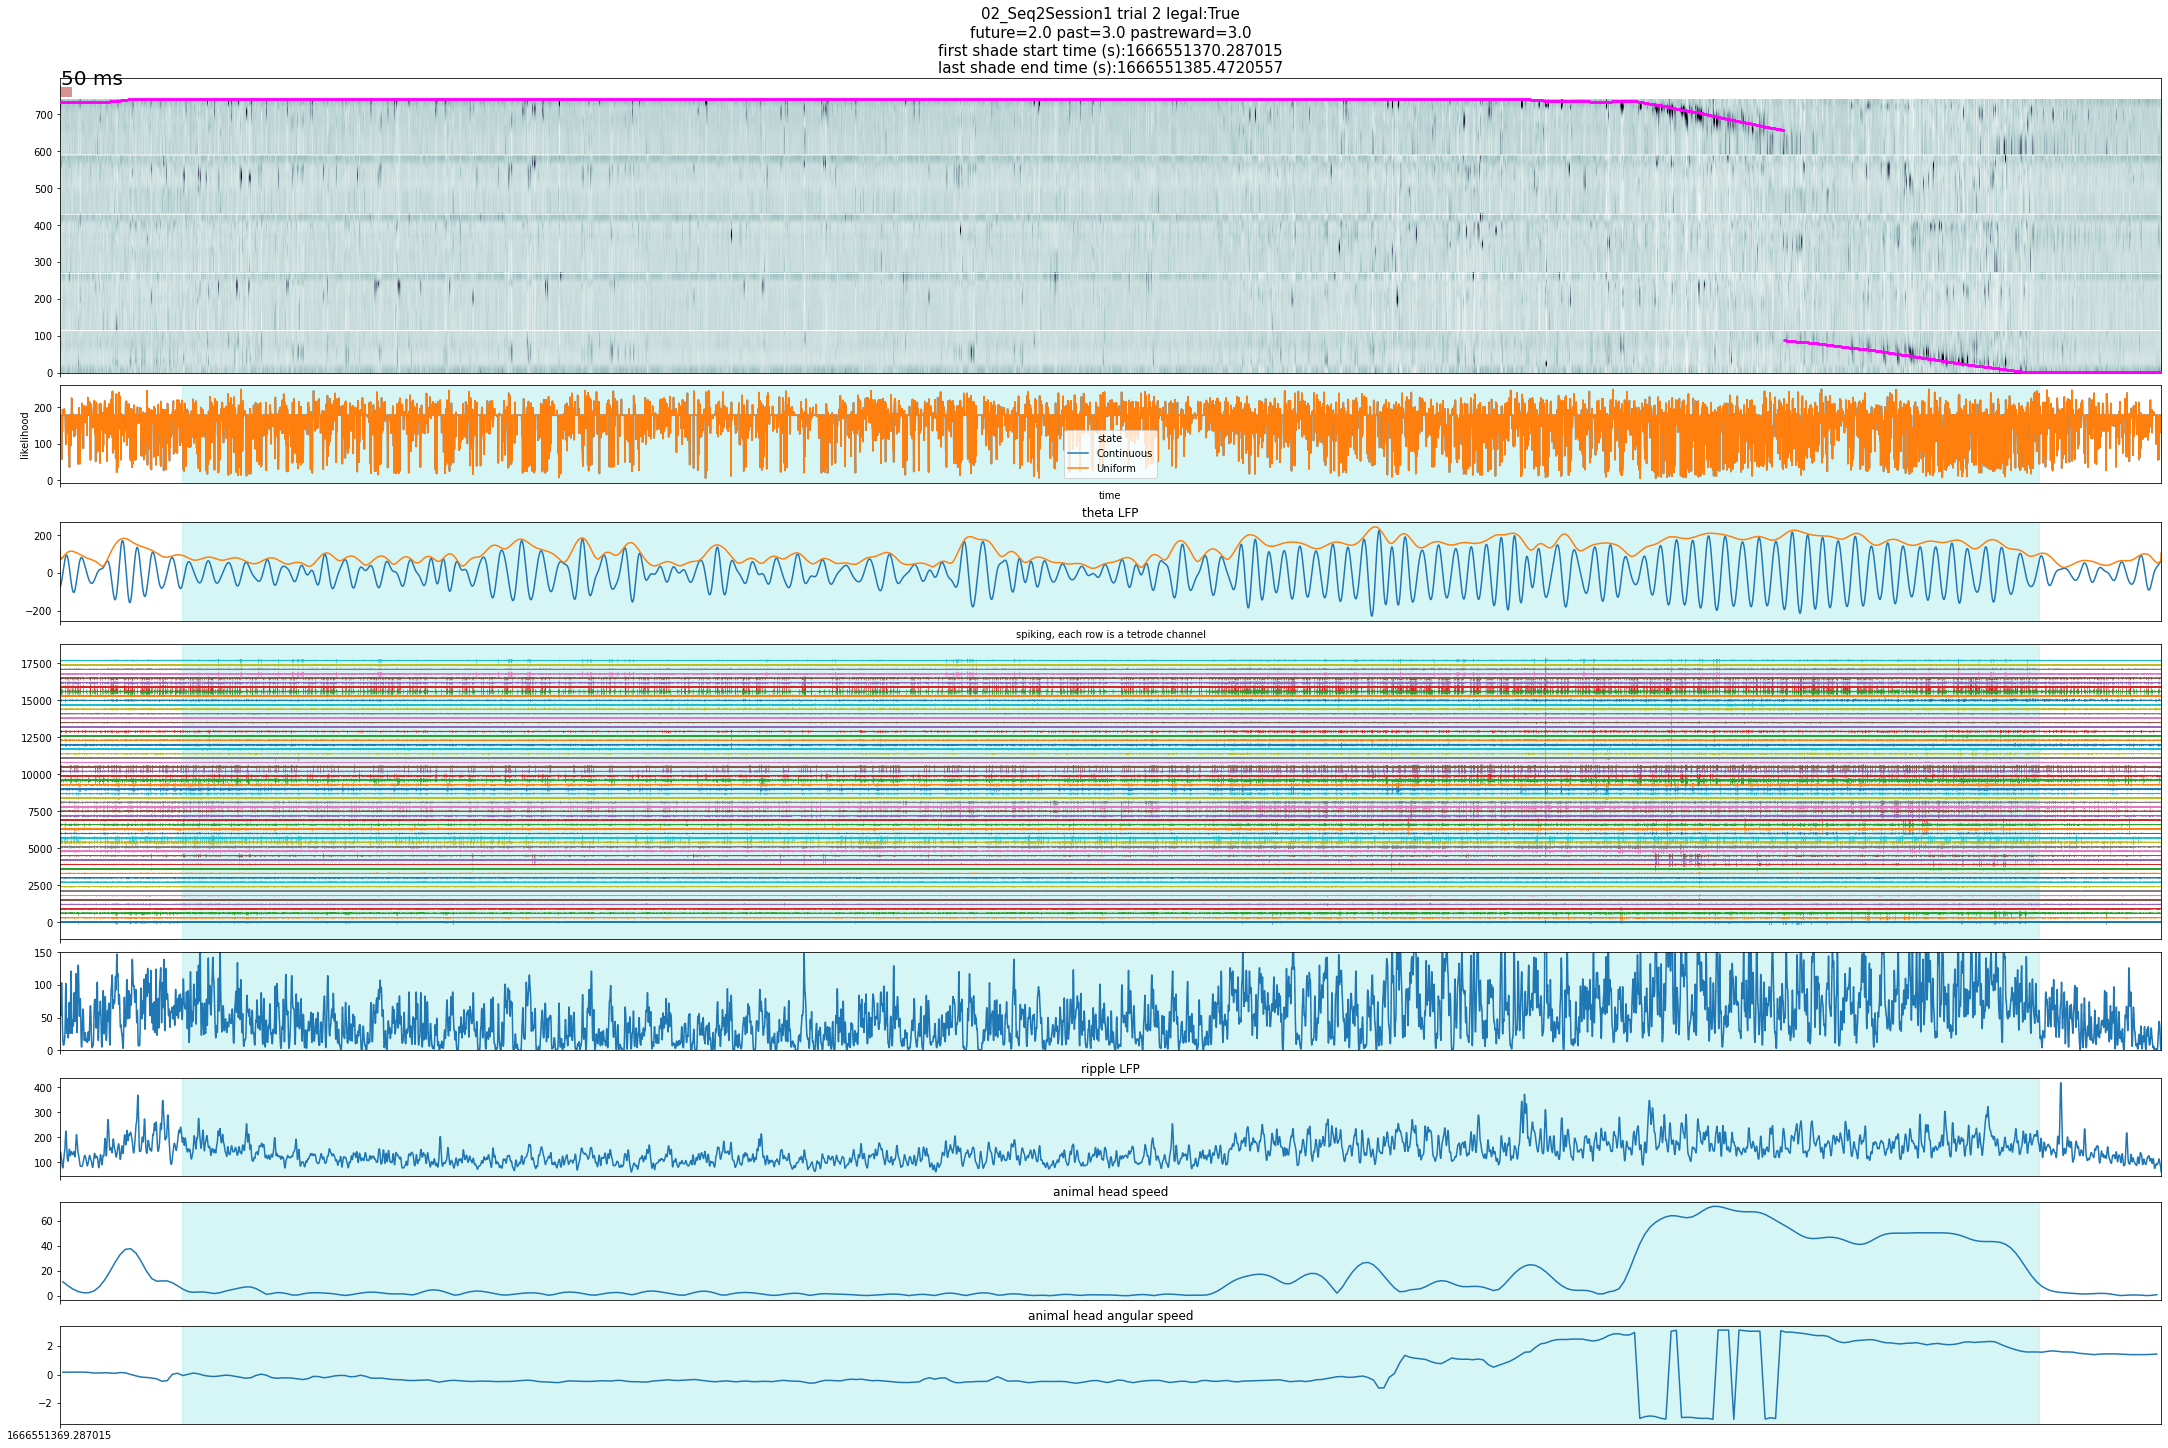

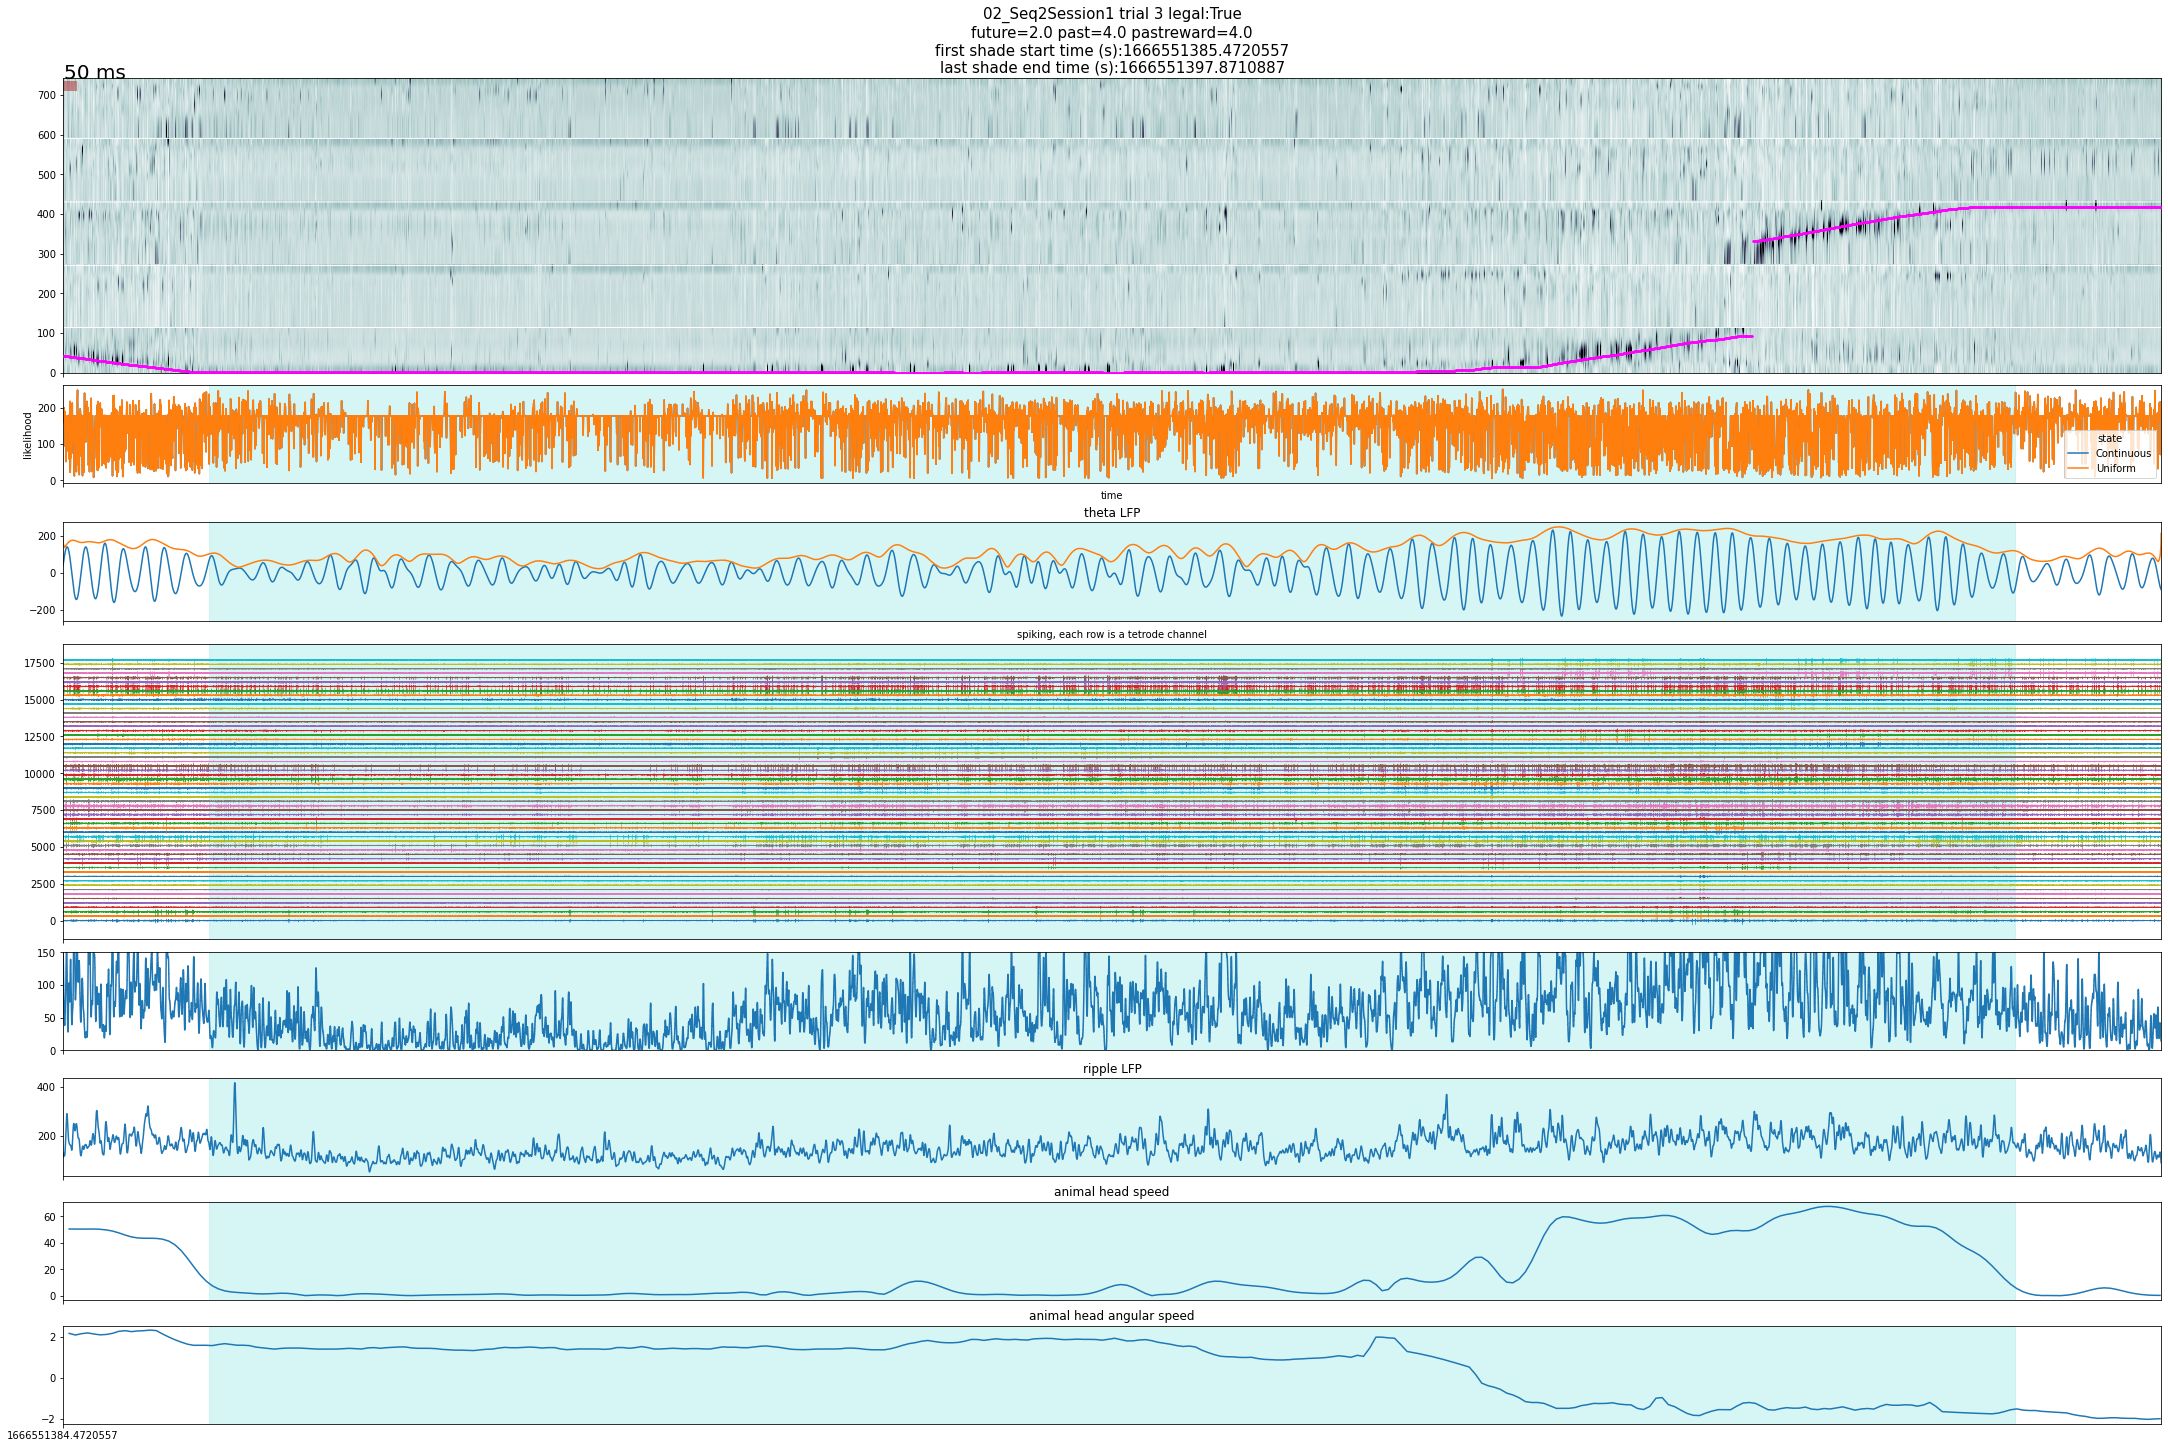

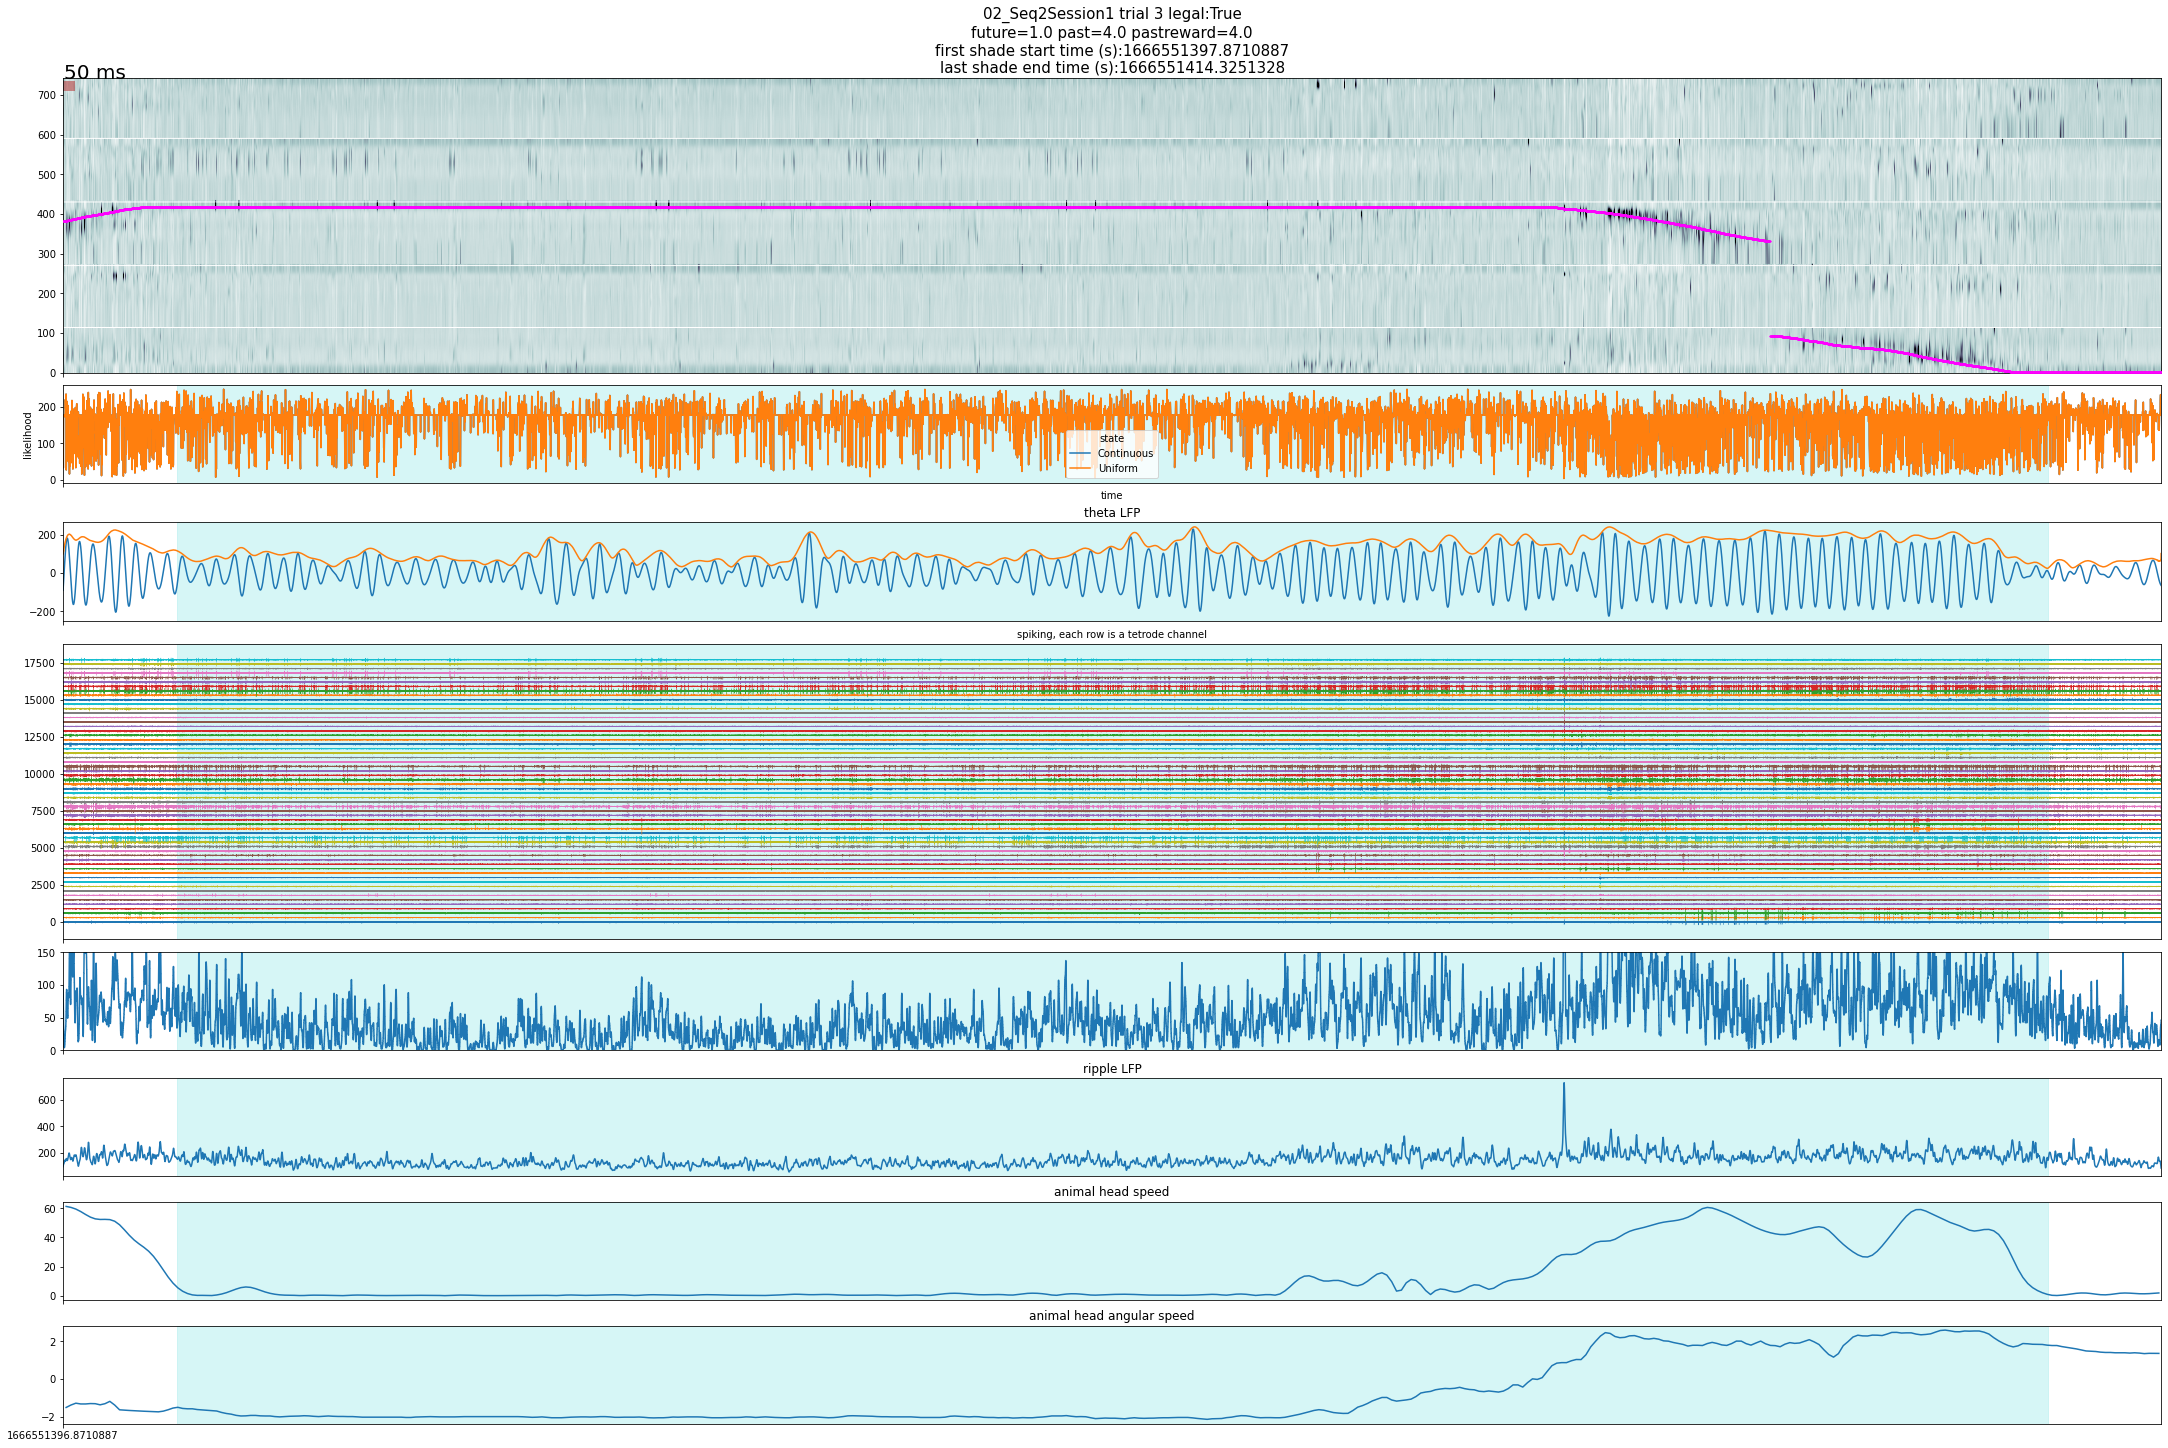

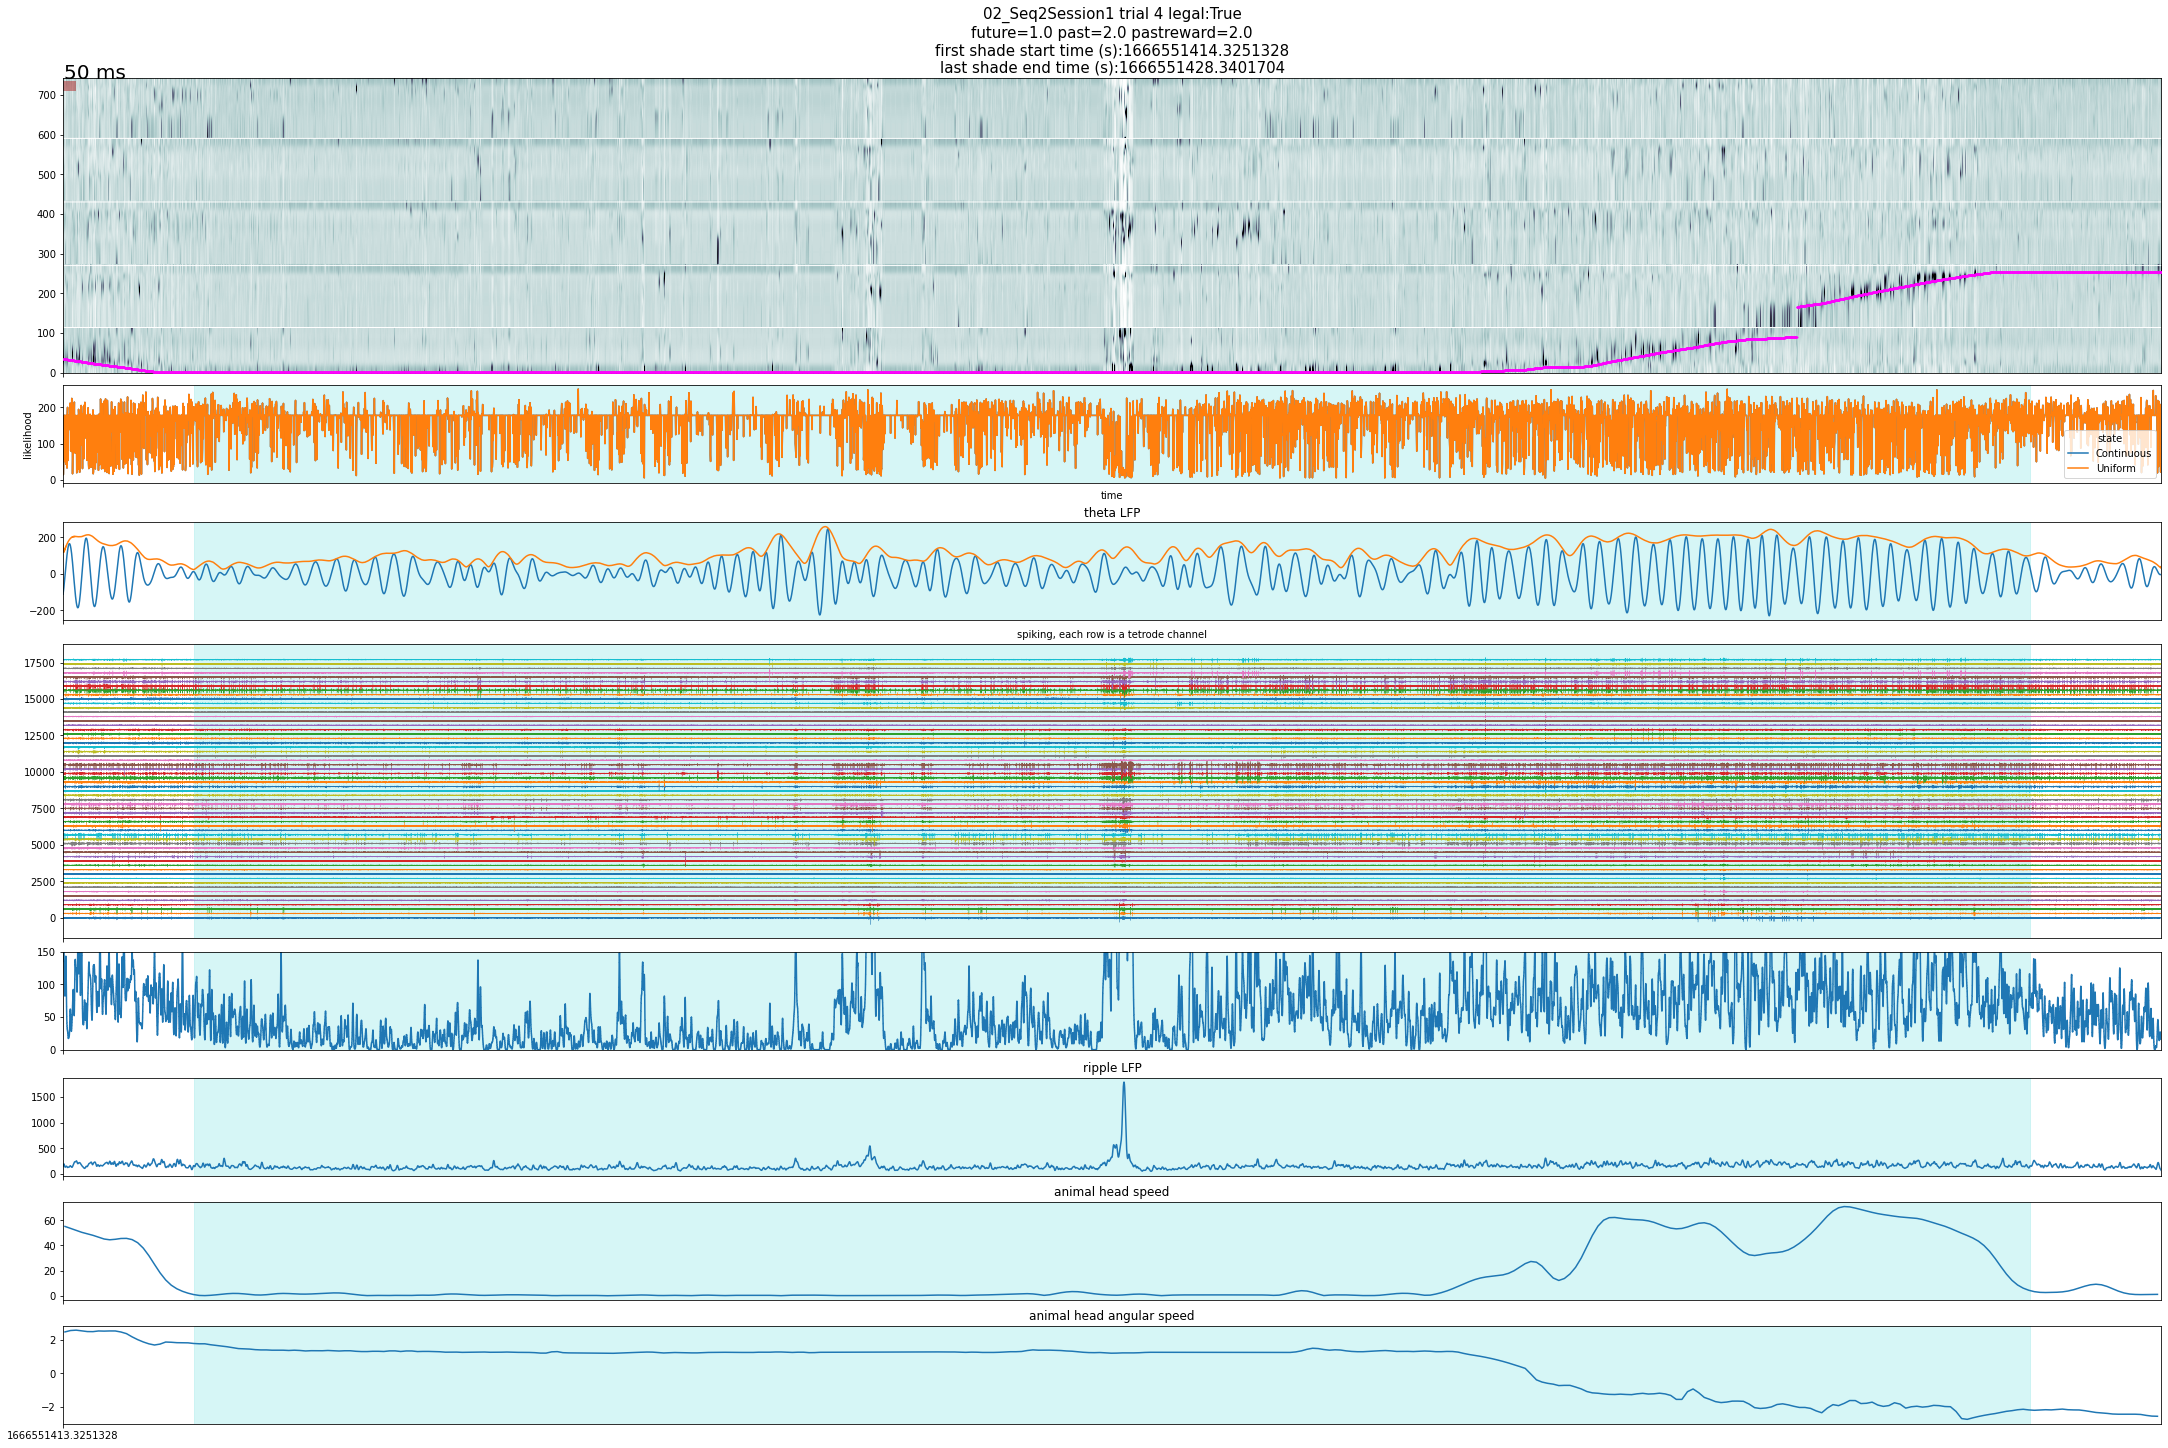

In [ ]:
epoch_num=2
likelihood = True;
plot_all_trials(nwb_copy_file_name,epoch_num,likelihood)

In [143]:
%debug

> /tmp/ipykernel_3192489/2748742610.py(31)plot_all_trials()
     29 
     30         '''HOME PLOT'''
---> 31         t0=df.loc[t,'timestamp_H']
     32         if np.isnan(t0):
     33             t0=df.loc[t-1,'timestamp_O']+2



ipdb>  log_df.loc[t,'timestamp_H']


1666644061.186362


ipdb>  log_df.loc[t,'future_O']


4.0


ipdb>  exit
